# Introduction to Wild Blueberry Yield Prediction

## Overview

In this tutorial, you will learn how to predict the yield of wild blueberries using machine learning techniques.

### Load Libraries

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score , GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

### Load Data

In [2]:
# Load the CSV file into a DataFrame
df = pd.read_csv('WildBlueberryPollinationSimulationData.csv')

In [3]:
# Get shape of the data
df.shape

(777, 18)

### Data Overview

In [4]:
# Display the first few rows of the DataFrame
print('==================== HEAD OF THE DATAFRAME ====================')
print(df.head())


# Get a summary of the DataFrame
print('==================== DESCRIPTION OF THE DATAFRAME ====================')

print(df.describe())

# Check for missing values
print('==================== MISSING VALUES ====================')

print(df.isnull().sum())

==================== HEAD OF THE DATAFRAME ====================
   Row#  clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange  \
0     0       37.5      0.75     0.25     0.25   0.25              86.0   
1     1       37.5      0.75     0.25     0.25   0.25              86.0   
2     2       37.5      0.75     0.25     0.25   0.25              94.6   
3     3       37.5      0.75     0.25     0.25   0.25              94.6   
4     4       37.5      0.75     0.25     0.25   0.25              86.0   

   MinOfUpperTRange  AverageOfUpperTRange  MaxOfLowerTRange  MinOfLowerTRange  \
0              52.0                  71.9              62.0              30.0   
1              52.0                  71.9              62.0              30.0   
2              57.2                  79.0              68.2              33.0   
3              57.2                  79.0              68.2              33.0   
4              52.0                  71.9              62.0              30.0   

### Exploratory Data Analysis (EDA)

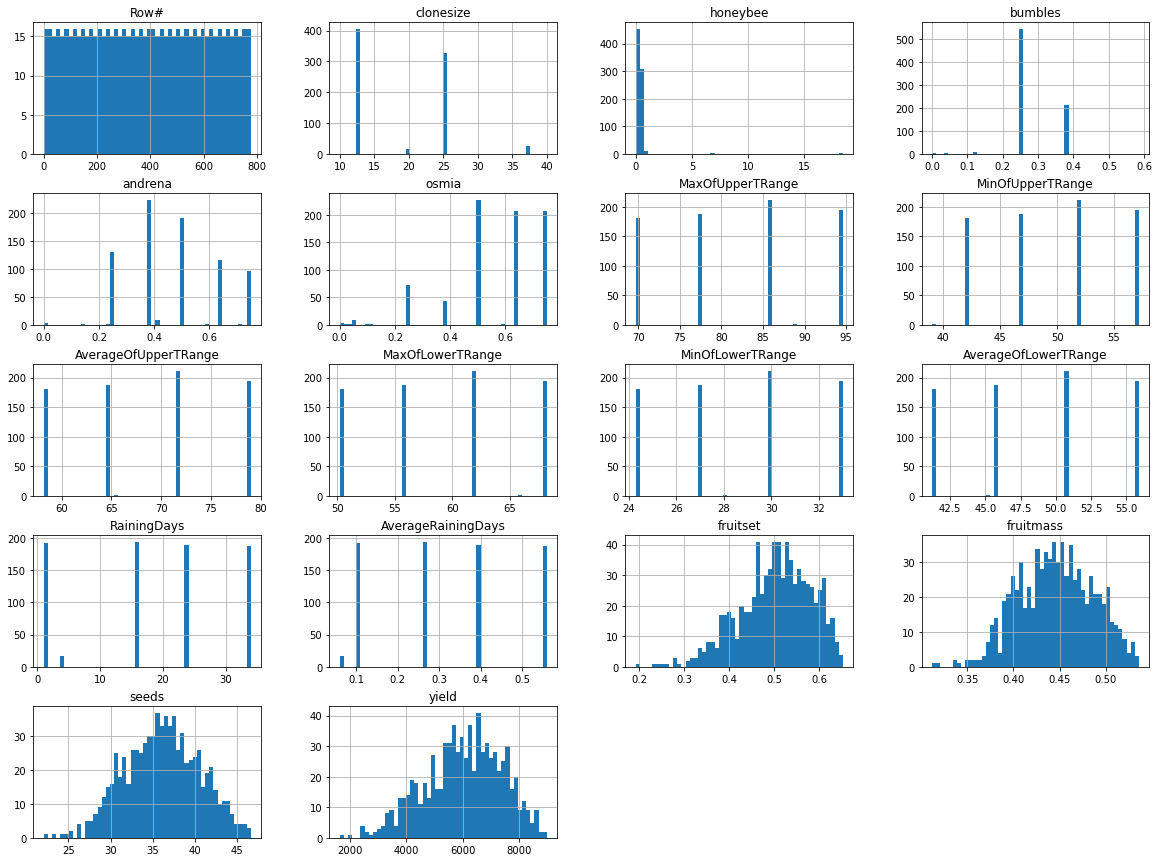

In [6]:
# Plot histograms for all numeric columns
df.hist(bins=50, figsize=(20, 15))
plt.show()

In [7]:
# Find missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

# To get the percentage of missing data in each column
missing_percentage = (df.isnull().sum() / len(df)) * 100
print("Percentage of missing data in each column:")
print(missing_percentage)

Missing values in each column:
Row#                    0
clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
MaxOfUpperTRange        0
MinOfUpperTRange        0
AverageOfUpperTRange    0
MaxOfLowerTRange        0
MinOfLowerTRange        0
AverageOfLowerTRange    0
RainingDays             0
AverageRainingDays      0
fruitset                0
fruitmass               0
seeds                   0
yield                   0
dtype: int64
Percentage of missing data in each column:
Row#                    0.0
clonesize               0.0
honeybee                0.0
bumbles                 0.0
andrena                 0.0
osmia                   0.0
MaxOfUpperTRange        0.0
MinOfUpperTRange        0.0
AverageOfUpperTRange    0.0
MaxOfLowerTRange        0.0
MinOfLowerTRange        0.0
AverageOfLowerTRange    0.0
RainingDays             0.0
AverageRainingDays      0.0
fruitset                0.0
fruitmass               0

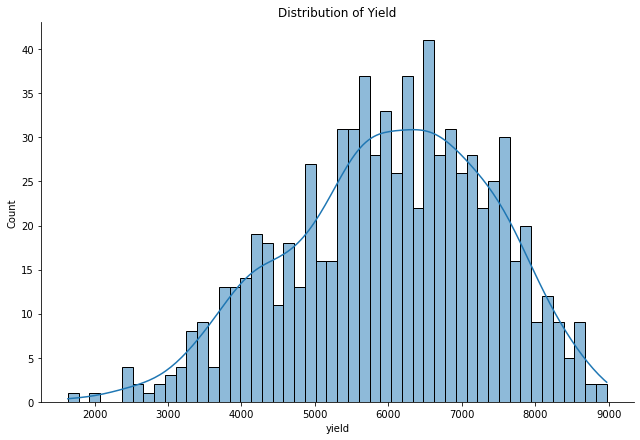

In [19]:
# Distribution Plot of target variable.
sns.displot(df['yield'], kde=True, bins=50, height=6, aspect=1.5)
plt.title("Distribution of Yield")
plt.show()

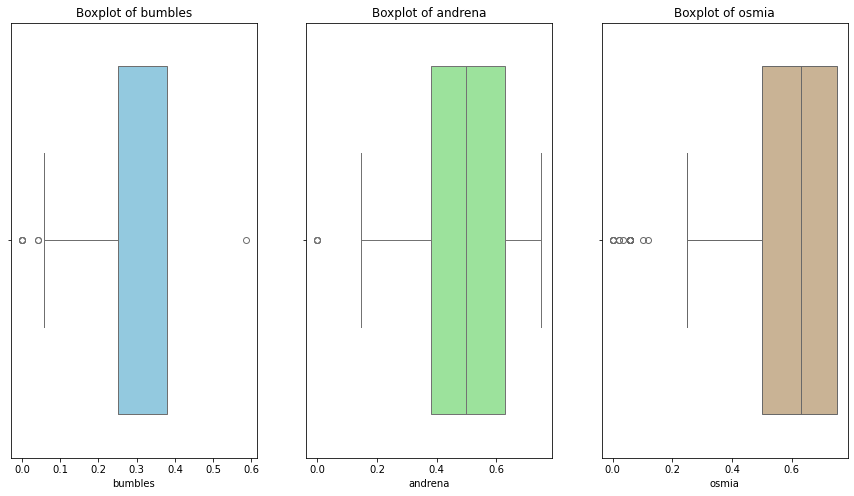

In [26]:

# List of column names for which you want to create boxplots
columns_to_plot = ['bumbles', 'andrena', 'osmia']
colors = ['skyblue', 'lightgreen', 'tan']  # Define a list of colors for the boxes

# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=len(columns_to_plot), figsize=(len(columns_to_plot) * 5, 8))

# Loop through the columns and create a boxplot in each subplot
for ax, column, color in zip(axes, columns_to_plot, colors):
    # Create the boxplot with Seaborn and set the fill color
    sns.boxplot(x=df[column], ax=ax, color=color)
    ax.set_title(f'Boxplot of {column}')

# # Adjust the layout so that titles and labels don't overlap
# plt.tight_layout()

# # Display the plot
plt.show()

In [5]:
# Define a function to find outliers using IQR
def find_outliers_by_IQR(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
    return outliers

In [6]:
# Example usage for column 'ColumnName'
outliers = find_outliers_by_IQR(df, 'bumbles')
print(f"Outliers in 'bumbles':")
print(outliers)

Outliers in 'bumbles':
     Row#  clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange  \
761   761       20.0      6.64    0.000    0.000  0.000              86.0   
762   762       20.0     18.43    0.000    0.000  0.000              86.0   
765   765       20.0     18.43    0.042    0.147  0.021              86.0   
766   766       20.0      0.00    0.042    0.147  0.021              86.0   
767   767       20.0      0.00    0.585    0.000  0.000              86.0   
768   768       20.0      0.00    0.000    0.585  0.000              86.0   
769   769       20.0      0.00    0.000    0.000  0.585              86.0   

     MinOfUpperTRange  AverageOfUpperTRange  MaxOfLowerTRange  \
761              52.0                  71.9              62.0   
762              52.0                  71.9              62.0   
765              52.0                  71.9              62.0   
766              52.0                  71.9              62.0   
767              52.0              

In [7]:
# If you want to check for outliers in multiple columns
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    outliers = find_outliers_by_IQR(df, column)
    if not outliers.empty:
        print(f"Outliers in '{column}':")
        print(outliers)

Outliers in 'honeybee':
     Row#  clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange  \
761   761       20.0      6.64    0.000    0.000  0.000              86.0   
762   762       20.0     18.43    0.000    0.000  0.000              86.0   
763   763       20.0      6.64    0.065    0.229  0.033              86.0   
765   765       20.0     18.43    0.042    0.147  0.021              86.0   

     MinOfUpperTRange  AverageOfUpperTRange  MaxOfLowerTRange  \
761              52.0                  71.9              62.0   
762              52.0                  71.9              62.0   
763              52.0                  71.9              62.0   
765              52.0                  71.9              62.0   

     MinOfLowerTRange  AverageOfLowerTRange  RainingDays  AverageRainingDays  \
761              30.0                  50.8         3.77                0.06   
762              30.0                  50.8         3.77                0.06   
763              30.0   

In [ ]:
# # Remove outliers example
# # Define a function to remove outliers using IQR
# def remove_outliers_by_IQR(dataframe, column):
#     Q1 = dataframe[column].quantile(0.25)
#     Q3 = dataframe[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     # Filter out outliers and keep valid entries
#     dataframe_clean = dataframe[(dataframe[column] >= lower_bound) & (dataframe[column] <= upper_bound)]
#     return dataframe_clean

# # Example usage for column 'ColumnName'
# df_clean = remove_outliers_by_IQR(df, 'ColumnName')
# print(f"Data without outliers in 'ColumnName':")
# print(df_clean)

# # If you want to remove outliers in multiple columns and keep only rows that are not outliers in any of the columns
# for column in df.select_dtypes(include=['float64', 'int64']).columns:
#     df = remove_outliers_by_IQR(df, column)

# # df now contains no outliers in any of the numeric columns
# print(f"Data without outliers in all columns:")
# print(df)

In [10]:
# Calculate correlations between columns
correlations = df.corr()
print(correlations)

                          Row#  clonesize  honeybee   bumbles   andrena  \
Row#                  1.000000   0.438706  0.192404  0.331999  0.446898   
clonesize             0.438706   1.000000  0.119745  0.004807 -0.008451   
honeybee              0.192404   0.119745  1.000000 -0.233954 -0.125913   
bumbles               0.331999   0.004807 -0.233954  1.000000  0.010758   
andrena               0.446898  -0.008451 -0.125913  0.010758  1.000000   
osmia                 0.288531  -0.139049 -0.189058  0.293665  0.387379   
MaxOfUpperTRange     -0.018204   0.034157  0.026359 -0.022863 -0.026497   
MinOfUpperTRange     -0.029893   0.032854  0.025467 -0.005801 -0.023887   
AverageOfUpperTRange -0.023144   0.033752  0.026365 -0.015821 -0.025578   
MaxOfLowerTRange     -0.016947   0.034295  0.026477 -0.024662 -0.026775   
MinOfLowerTRange     -0.022430   0.033768  0.026104 -0.016801 -0.025623   
AverageOfLowerTRange -0.024338   0.033566  0.025647 -0.013985 -0.025115   
RainingDays          -0.0

<Axes: >

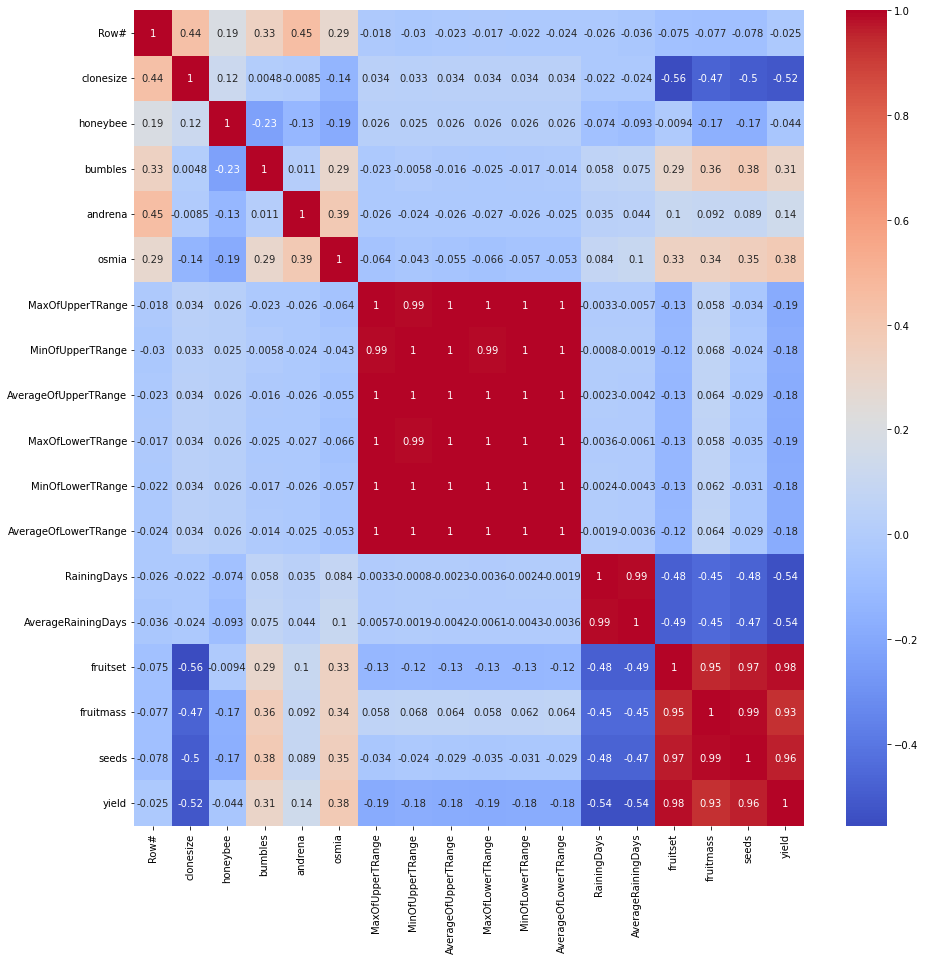

In [14]:
# Plot a correlation matrix heatmap
plt.figure(figsize=(15, 15))  # Increase figure size
sns.heatmap(correlations, annot=True, cmap='coolwarm')

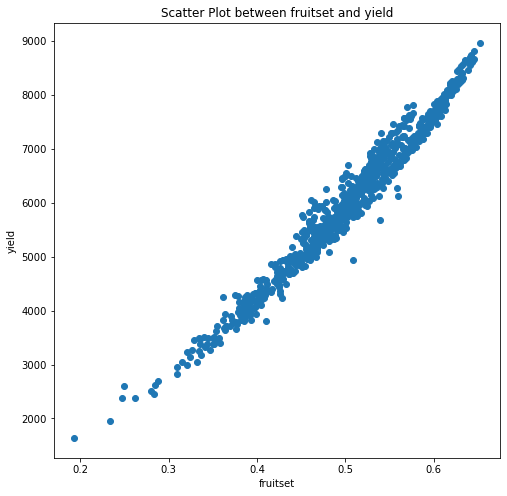

In [18]:
# Simple scatter plot between two variables
plt.figure(figsize=(8, 8))  # Increase figure size
plt.scatter(df['fruitset'], df['yield'])
plt.xlabel('fruitset')
plt.ylabel('yield')
plt.title('Scatter Plot between fruitset and yield')
plt.show()

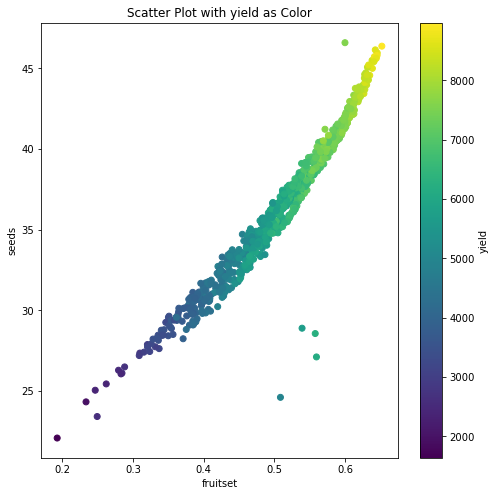

In [19]:
# Scatter plot with a third variable represented by color (e.g., 'yield')
plt.figure(figsize=(8, 8))  # Increase figure size
plt.scatter(df['fruitset'], df['seeds'], c=df['yield'])
plt.xlabel('fruitset')
plt.ylabel('seeds')
plt.colorbar(label='yield')  # Show color scale
plt.title('Scatter Plot with yield as Color')
plt.show()

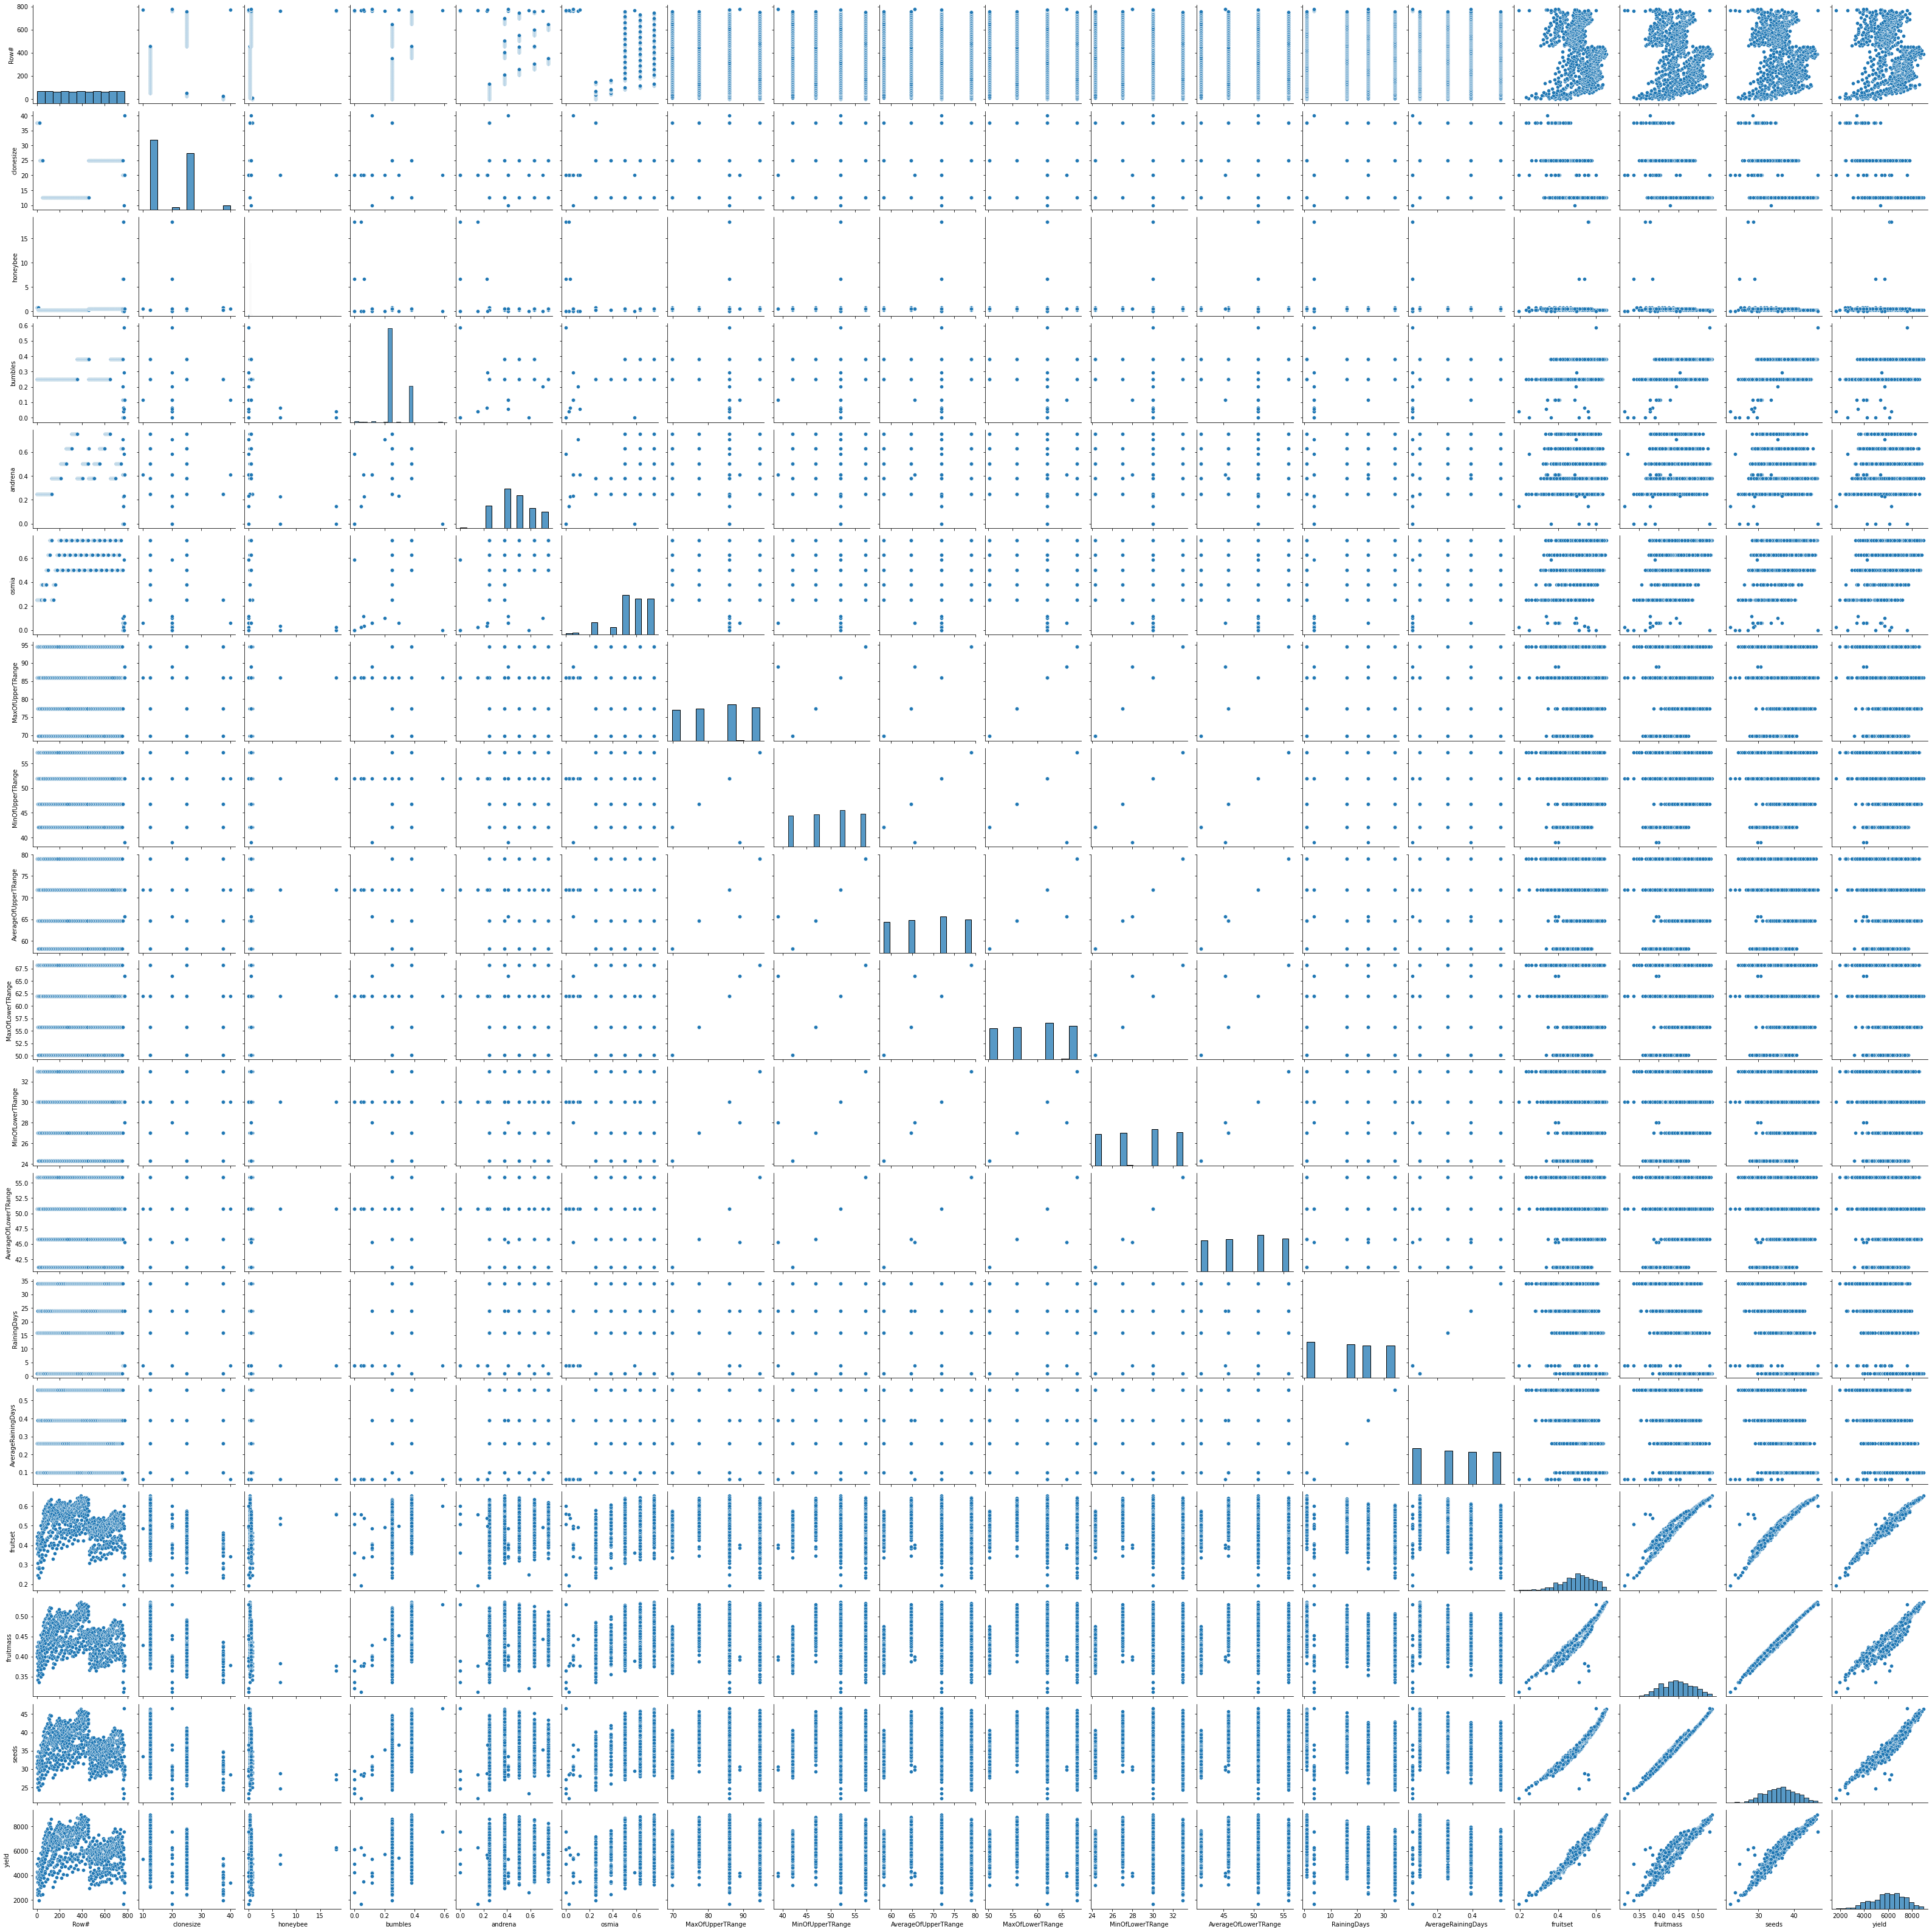

In [17]:
# This is not really needed
# # Pairplot for multiple pairwise scatter plots in a dataset
# import seaborn as sns
# sns.pairplot(df)
# plt.show()

### Preprocessing

In [18]:
# Drop Row# and set yield to y
y = df['yield']
df = df.drop(['Row#', 'yield'], axis=1)

In [19]:
# The independent variables set must include a constant
X = add_constant(df)

# Create a DataFrame that will contain the names of all the feature variables and their respective VIFs
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                 Feature         VIF
0                  const    0.000000
1              clonesize    3.800417
2               honeybee    3.479346
3                bumbles    2.232211
4                andrena    1.277828
5                  osmia    1.885464
6       MaxOfUpperTRange         inf
7       MinOfUpperTRange         inf
8   AverageOfUpperTRange         inf
9       MaxOfLowerTRange         inf
10      MinOfLowerTRange         inf
11  AverageOfLowerTRange         inf
12           RainingDays   64.103199
13    AverageRainingDays   71.317751
14              fruitset   80.871479
15             fruitmass  764.374648
16                 seeds  566.708415


d:\Softwares\Anaconda3\envs\tensorenv\lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
d:\Softwares\Anaconda3\envs\tensorenv\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [20]:
# Assuming 'df' is your DataFrame and 'vif_data' contains the VIF values
high_vif_features = vif_data[vif_data['VIF'] > 10]['Feature']
df_reduced = df.drop(columns=high_vif_features)
print("Original DF shape: ", df.shape)
print("Reduced DF shape",df_reduced.shape)

Original DF shape:  (777, 16)
Reduced DF shape (777, 5)


<Axes: >

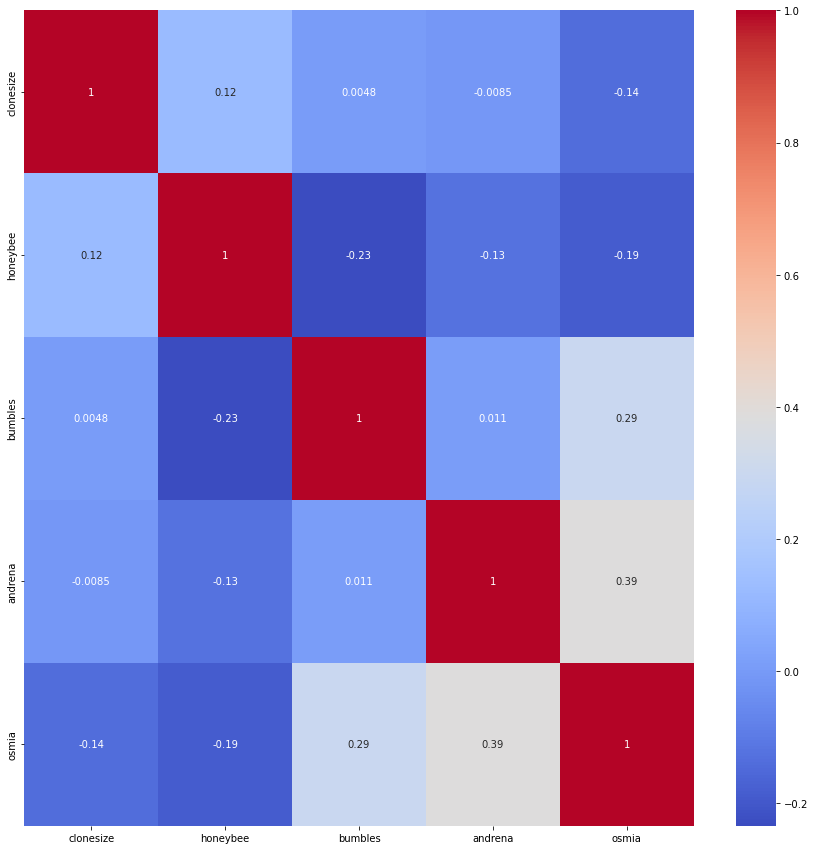

In [21]:
correlations_r = df_reduced.corr()
plt.figure(figsize=(15, 15))  # Increase figure size
sns.heatmap(correlations_r, annot=True, cmap='coolwarm')

### Feature Selection

In [40]:
# Assuming X is your input features DataFrame and y is your target variable (Series or ndarray)
X = df

# Number of top features to select
k = 7

# Create the SelectKBest object with the f_regression function
selector = SelectKBest(score_func=f_regression, k=k)

# Fit the selector to your data
X_new = selector.fit_transform(X, y)

# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)

# Get the names of the selected features if you have a DataFrame
selected_feature_names = X.columns[selected_indices]

print("Selected features:", selected_feature_names)

Selected features: Index(['clonesize', 'osmia', 'RainingDays', 'AverageRainingDays', 'fruitset',
       'fruitmass', 'seeds'],
      dtype='object')


### Model Testing

In [41]:
# Assuming df is your DataFrame and 'target' is the name of the target column
X = df[selected_feature_names]
# y = df['yield']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize the XGBoost regressor
xg_reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    colsample_bytree=0.3,
    learning_rate=0.1,
    max_depth=5,
    alpha=10,
    n_estimators=10,
)

# Default values for parameters
# xg_reg = xgb.XGBRegressor(
#     objective="reg:squarederror",
#     colsample_bytree=1,
#     learning_rate=0.3,
#     max_depth=6,
#     alpha=0,
#     n_estimators=100,
# )

# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)

# Predict the model's performance on the test set
y_pred = xg_reg.predict(X_test)

# Evaluate the model's performance
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

RMSE: 2168.2641324242536


### Paramter Tuning

In [ ]:
# Optimization using Bayesian Optimization

# Define the space of hyperparameters to search
space = {
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.choice('max_depth', [3, 4, 5, 6, 7, 8, 9, 10]),
    'alpha': hp.choice('alpha', [0, 1, 5, 10, 50, 100]),
    'n_estimators': hp.choice('n_estimators', [50, 100, 200, 300, 400, 500])
}

# Objective function that hyperopt will minimize
def objective(hyperparams):
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        colsample_bytree=hyperparams['colsample_bytree'],
        learning_rate=hyperparams['learning_rate'],
        max_depth=int(hyperparams['max_depth']),
        alpha=hyperparams['alpha'],
        n_estimators=int(hyperparams['n_estimators']),
        seed=42
    )
    # Perform cross-validation
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    # Calculate the mean squared error and convert to a positive number (as hyperopt minimizes the objective)
    mean_score = -scores.mean()
    return {'loss': mean_score, 'status': STATUS_OK}

# Run the algorithm
trials = Trials()
best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=10,  # Set this to the number of evaluations you want
                        trials=trials)

print("The best hyperparameters are:", "\n")
print(best_hyperparams)

# Cast the hyperparameters to the correct type if necessary
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
best_hyperparams['n_estimators'] = int(best_hyperparams['n_estimators'])

# Retrain the model with the best hyperparameters
best_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=best_hyperparams['colsample_bytree'],
    learning_rate=best_hyperparams['learning_rate'],
    max_depth=best_hyperparams['max_depth'],
    alpha=best_hyperparams['alpha'],
    n_estimators=best_hyperparams['n_estimators'],
    seed=42
)

best_model.fit(X, y)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE after tuning: {rmse}")

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [00:16<00:00,  1.64s/trial, best loss: 44281.00250046118]
The best hyperparameters are: 

{'alpha': 2, 'colsample_bytree': 0.7256768918728526, 'learning_rate': 0.16067545747516435, 'max_depth': 3, 'n_estimators': 3}
RMSE after tuning: 3598.558854940091


In [45]:
# Optimization using GridSearchCV

# Initialize the XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror')

# Parameter to vary and test
parameters = {
    'colsample_bytree': [0.3, 0.5, 0.7, 1],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7],
    'alpha': [1, 10, 100],
    'n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(estimator=xg_reg, param_grid=parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_parameters = grid_search.best_params_
print("Best parameters found: ", best_parameters)

# Create a new regressor with the best parameters
xg_reg_best = xgb.XGBRegressor(**best_parameters)
xg_reg_best.fit(X_train, y_train)

# Predict the model's performance on the test set
y_pred_best = xg_reg_best.predict(X_test)

# Evaluate the model's performance
rmse_best = mean_squared_error(y_test, y_pred_best, squared=False)
print(f"RMSE after tuning: {rmse_best}")

Best parameters found:  {'alpha': 100, 'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
RMSE after tuning: 146.2448711794631
